In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd

filename = 'factoryReports.csv'
data = pd.read_csv(filename, dtype={'Category': 'string'})

print(data.head())


                                         Description            Category  \
0  Items are occasionally getting stuck in the sc...  Mechanical Failure   
1  Loud rattling and banging sounds are coming fr...  Mechanical Failure   
2  There are cuts to the power when starting the ...  Electronic Failure   
3                 Fried capacitors in the assembler.  Electronic Failure   
4                           Mixer tripped the fuses.  Electronic Failure   

  Urgency          Resolution   Cost  
0  Medium    Readjust Machine     45  
1  Medium    Readjust Machine     35  
2    High    Full Replacement  16200  
3    High  Replace Components    352  
4     Low   Add to Watch List     55  


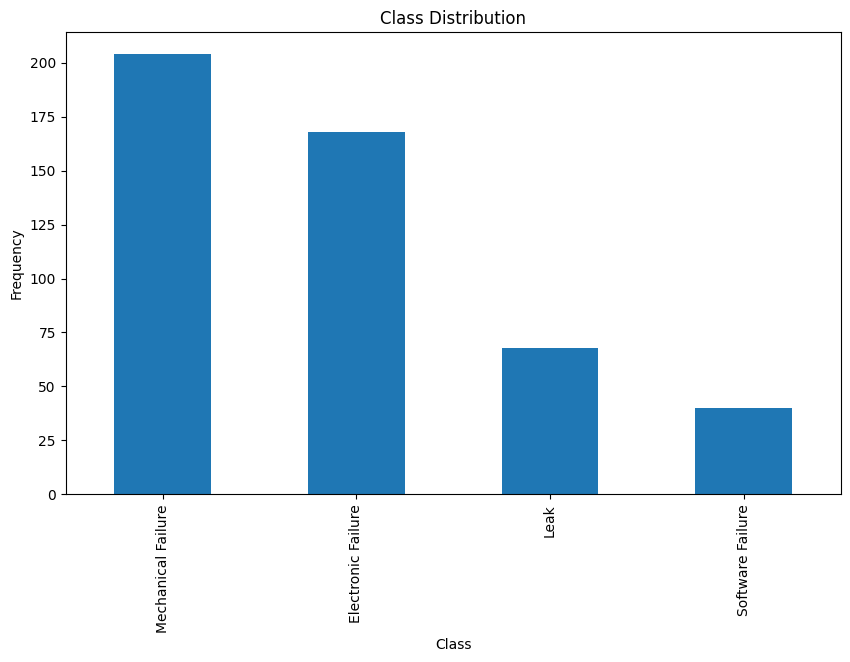

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
filename = 'factoryReports.csv'
data = pd.read_csv(filename)

# Convert 'Category' column to categorical
data['Category'] = data['Category'].astype('category')
classNames = data['Category'].cat.categories

# Plot Class Distribution
plt.figure(figsize=(10,6))
data['Category'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets using stratified holdout
dataTrain, dataValidation = train_test_split(data, test_size=0.2, stratify=data['Category'], random_state=42)


# Extract 'Description' and 'Category' columns for training and validation
textDataTrain = dataTrain['Description']
textDataValidation = dataValidation['Description']
YTrain = dataTrain['Category']
YValidation = dataValidation['Category']


In [ ]:
!pip install wordcloud


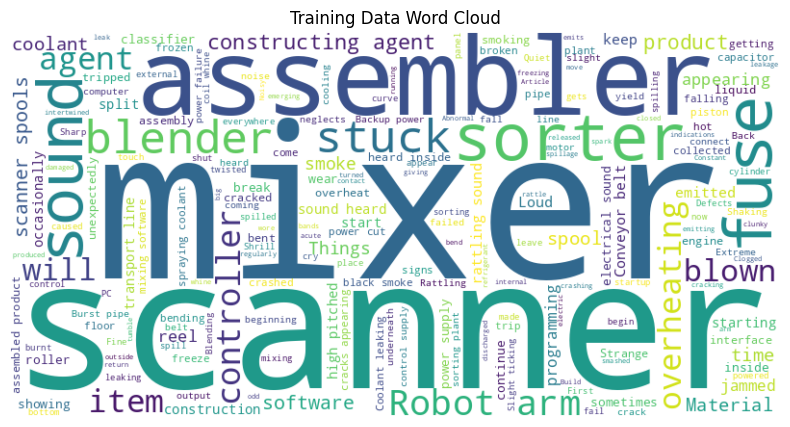

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all descriptions into a single string
all_descriptions = ' '.join(textDataTrain)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Training Data Word Cloud')
plt.show()


In [ ]:
import string

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

# Apply text preprocessing to training and validation data
documentsTrain = textDataTrain.apply(preprocess_text)
documentsValidation = textDataValidation.apply(preprocess_text)


In [ ]:
print(documentsTrain.iloc[:5])


430           mixer refrigerant has spilled on the floor
259                          sorter yields browned items
354    crack appearing on the outside panel of the ro...
173                    things will keep falling off belt
241    there are some highpitched electrical sounds e...
Name: Description, dtype: object


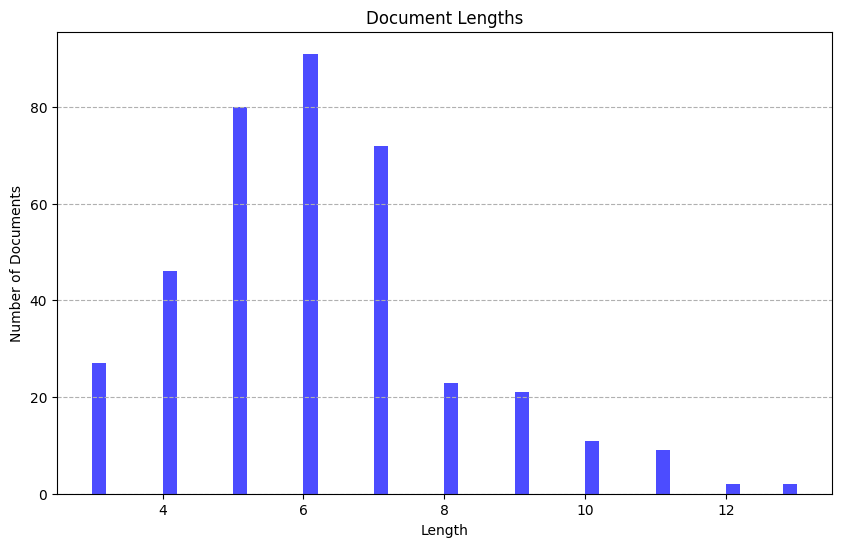

In [ ]:
# Compute document lengths
document_lengths = documentsTrain.apply(lambda x: len(x.split()))

# Plot histogram of document lengths
plt.figure(figsize=(10,6))
plt.hist(document_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Document Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Documents')
plt.grid(axis='y', linestyle='--')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def doc2sequence(tokenizer, texts, length):
    # Tokenize texts
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to the specified length
    padded_sequences = pad_sequences(sequences, maxlen=length, padding='post')

    return padded_sequences


In [ ]:
# Define the sequence length
sequenceLength = 10

# Create a tokenizer and fit on training documents
tokenizer = Tokenizer()
tokenizer.fit_on_texts(documentsTrain)

# Convert documentsTrain to sequences
XTrain = doc2sequence(tokenizer, documentsTrain, sequenceLength)

# Display the first 5 sequences
print(XTrain[:5])


[[  3 185  34 142  13   1  97   0   0   0]
 [ 11 186 262  37   0   0   0   0   0   0]
 [116  32  13   1 187 188   6   1  14  17]
 [ 44  28 143  98  45  38   0   0   0   0]
 [ 67  15  35  99  68  18  54  39   1   3]]


In [ ]:
# Convert documentsValidation to sequences
XValidation = doc2sequence(tokenizer, documentsValidation, sequenceLength)

# Display the first 5 sequences
print(XValidation[:5])


[[140  12  26  43   4   0   0   0   0   0]
 [  3  74 222   0   0   0   0   0   0   0]
 [ 21  30   2   1  94   0   0   0   0   0]
 [174 137 107  26   2   1   3   0   0   0]
 [265  16 194 126   3   0   0   0   0   0]]


In [ ]:
#creating Lstm Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

inputSize = 1
embeddingDimension = 50
numHiddenUnits = 80

# Determine the number of unique words (vocabulary size) from the Tokenizer
numWords = len(tokenizer.word_index) + 1  # +1 for the padding token

# Determine the number of classes
numClasses = len(classNames)

# Define the model
model = Sequential([
    Embedding(input_dim=numWords, output_dim=embeddingDimension, input_length=sequenceLength),
    LSTM(units=numHiddenUnits, return_sequences=False),
    Dense(units=numClasses, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 50)            21350     
                                                                 
 lstm_1 (LSTM)               (None, 80)                41920     
                                                                 
 dense_1 (Dense)             (None, 4)                 324       
                                                                 
Total params: 63594 (248.41 KB)
Trainable params: 63594 (248.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam()

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define training options ()
batch_size = 16
epochs = 10  # here we can adjust the number of epochs

# Training the model
history = model.fit(XTrain, YTrain.cat.codes,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(XValidation, YValidation.cat.codes),
                    shuffle=True,
                    verbose=1)


Epoch 1/10
24/24 [==============================] - 3s 33ms/step - loss: 1.3173 - accuracy: 0.4115 - val_loss: 1.1991 - val_accuracy: 0.4271
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 1.1736 - accuracy: 0.4245 - val_loss: 1.0903 - val_accuracy: 0.4271
Epoch 3/10
24/24 [==============================] - 0s 15ms/step - loss: 0.8922 - accuracy: 0.5182 - val_loss: 0.7193 - val_accuracy: 0.6979
Epoch 4/10
24/24 [==============================] - 0s 14ms/step - loss: 0.4070 - accuracy: 0.8177 - val_loss: 0.5749 - val_accuracy: 0.8125
Epoch 5/10
24/24 [==============================] - 0s 15ms/step - loss: 0.2233 - accuracy: 0.9010 - val_loss: 0.6391 - val_accuracy: 0.7708
Epoch 6/10
24/24 [==============================] - 0s 14ms/step - loss: 0.1739 - accuracy: 0.9219 - val_loss: 0.6151 - val_accuracy: 0.8125
Epoch 7/10
24/24 [==============================] - 0s 16ms/step - loss: 0.0933 - accuracy: 0.9844 - val_loss: 0.5746 - val_accuracy: 0.8229
Epoch 8/10
24

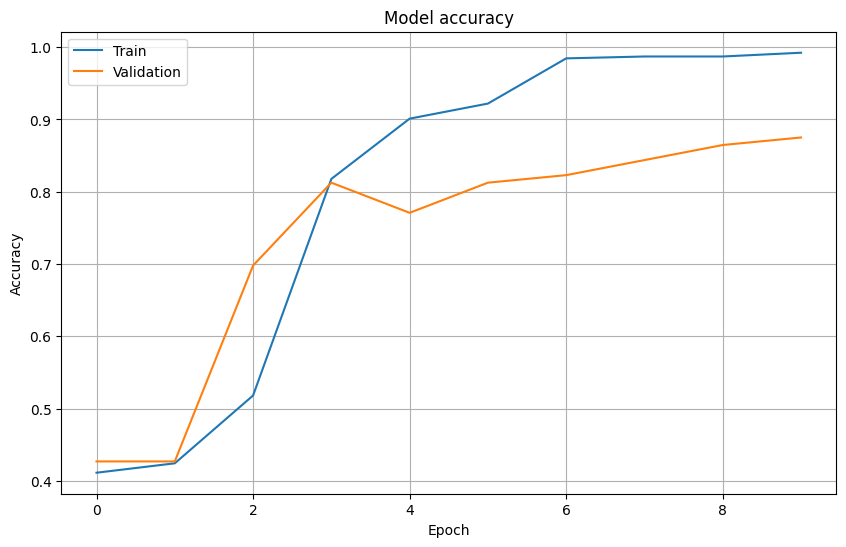

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
# New reports
reportsNew = [
    "Coolant is pooling underneath sorter.",
    "Sorter blows fuses at start up.",
    "There are some very loud rattling sounds coming from the assembler."
]

# Preprocess the new reports
processed_reports = [preprocess_text(report) for report in reportsNew]

# Convert new reports to sequences using the same tokenizer
sequences_new = doc2sequence(tokenizer, processed_reports, sequenceLength)

# Make predictions
predictions = model.predict(sequences_new)

# Convert predictions to labels
labels_new = [classNames[np.argmax(prediction)] for prediction in predictions]

print(labels_new)


1/1 [==============================] - 0s 56ms/step
['Leak', 'Electronic Failure', 'Electronic Failure']


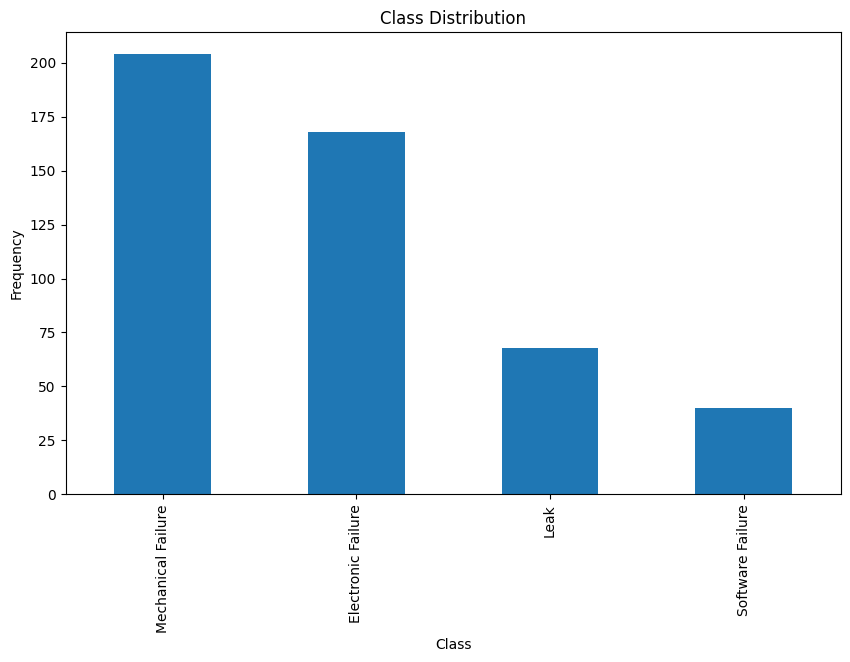

Epoch 1/10
24/24 [==============================] - 3s 31ms/step - loss: 1.3005 - accuracy: 0.3958 - val_loss: 1.1988 - val_accuracy: 0.4375
Epoch 2/10
24/24 [==============================] - 0s 7ms/step - loss: 1.1201 - accuracy: 0.4219 - val_loss: 0.9674 - val_accuracy: 0.4479
Epoch 3/10
24/24 [==============================] - 0s 7ms/step - loss: 0.7157 - accuracy: 0.6302 - val_loss: 0.4419 - val_accuracy: 0.8021
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.3655 - accuracy: 0.8333 - val_loss: 0.3787 - val_accuracy: 0.8229
Epoch 5/10
24/24 [==============================] - 0s 7ms/step - loss: 0.2713 - accuracy: 0.8750 - val_loss: 0.3302 - val_accuracy: 0.8333
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 0.2261 - accuracy: 0.9036 - val_loss: 0.3164 - val_accuracy: 0.8958
Epoch 7/10
24/24 [==============================] - 0s 13ms/step - loss: 0.1695 - accuracy: 0.9375 - val_loss: 0.3218 - val_accuracy: 0.9271
Epoch 8/10
24/24 [

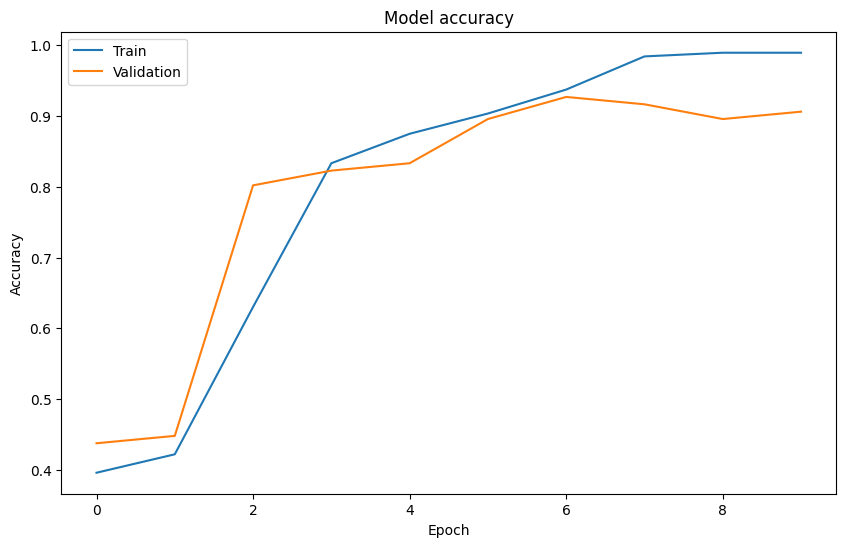

1/1 [==============================] - 0s 430ms/step
['Leak', 'Electronic Failure', 'Mechanical Failure']


In [ ]:

# Load data from CSV
filename = '/content/factoryReports.csv'
data = pd.read_csv(filename)

# Convert 'Category' column to categorical
data['Category'] = pd.Categorical(data['Category'])
classNames = data['Category'].cat.categories

# Visualize Class Distribution
plt.figure(figsize=(10,6))
data['Category'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

# Split data into training and validation sets
X_train, X_validation, Y_train, Y_validation = train_test_split(data['Description'], data['Category'], test_size=0.2, random_state=42)

# Text Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_validation_seq = tokenizer.texts_to_sequences(X_validation)

vocab_size = len(tokenizer.word_index) + 1

max_length = 10
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_validation_padded = pad_sequences(X_validation_seq, maxlen=max_length, padding='post')

# LSTM Model
embedding_dim = 50
num_hidden_units = 80
num_classes = len(classNames)

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(num_hidden_units),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(X_train_padded, Y_train.cat.codes, epochs=10, batch_size=16,
                    validation_data=(X_validation_padded, Y_validation.cat.codes), verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prediction
reportsNew = [
    "Coolant is pooling underneath sorter.",
    "Sorter blows fuses at start up.",
    "There are some very loud rattling sounds coming from the assembler."
]

reportsNew_seq = tokenizer.texts_to_sequences(reportsNew)
X_new_padded = pad_sequences(reportsNew_seq, maxlen=max_length, padding='post')

predictions = model.predict(X_new_padded)
labels_new = [classNames[np.argmax(prediction)] for prediction in predictions]
print(labels_new)


In [ ]:
import string

def preprocess_text(text_data):
    # Convert to lowercase
    text_data = text_data.lower()

    # Remove punctuation
    text_data = text_data.translate(str.maketrans('', '', string.punctuation))

    return text_data


In [ ]:
import string

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

# Example using one of the new reports
example_report = "Coolant is pooling underneath sorter."
processed_example = preprocess_text(example_report)
print(processed_example)



coolant is pooling underneath sorter


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDb movie reviews dataset
def load_imdb_dataset():
    dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
    train_dataset, test_dataset = dataset['train'], dataset['test']
    return train_dataset, test_dataset, info

# Preprocess datasets
def preprocess_datasets(train_dataset, test_dataset, buffer_size=10000, batch_size=64):
    train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size)
    test_dataset = test_dataset.padded_batch(batch_size)
    return train_dataset, test_dataset

# Build RNN model
def build_rnn_model(vocab_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Main function
def main():
    # Load dataset
    train_dataset, test_dataset, info = load_imdb_dataset()

    # Get encoder and vocab size
    encoder = info.features['text'].encoder
    vocab_size = encoder.vocab_size

    # Preprocess datasets
    train_dataset, test_dataset = preprocess_datasets(train_dataset, test_dataset)

    # Build RNN model
    model = build_rnn_model(vocab_size)

    # Train the model
    history = model.fit(train_dataset, epochs=2, validation_data=test_dataset)

    # Test with sample text
    sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie')
    encoded_text = encoder.encode(sample_text)
    encoded_text = tf.expand_dims(encoded_text, 0)

    # Prediction
    prediction = model.predict(encoded_text)

    # Check the prediction
    if prediction >= 0.0:  # Since using from_logits=True
        print("Positive")
    else:
        print("Negative")

if __name__ == "__main__":
    main()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete02W2DE/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete02W2DE/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete02W2DE/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Epoch 1/2
391/391 [==============================] - 915s 2s/step - loss: 0.5223 - accuracy: 0.7214 - val_loss: 0.4386 - val_accuracy: 0.7934
Epoch 2/2
1/1 [==============================] - 1s 838ms/step
Positive
